In [1]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import random
from collections import defaultdict
import copy
import ast
import csv
import numpy as np

dataset = Planetoid(root='../data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [2]:
GCN_GNNExplainer_explanations = {}
GCN_IG_explanations = {}
GAT_GNNExplainer_explanations = {}
GAT_IG_explanations = {}

with open("../results/Explanations_GCN_GNNExplainer.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            edge_indices = row[3]
            edge_indices_list = ast.literal_eval(edge_indices)
            edge_weights = row[4]
            edge_weights_list = ast.literal_eval(edge_weights)
            GCN_GNNExplainer_explanations[index] = (edge_indices_list, edge_weights_list)

with open("../results/Explanations_GCN_IntegratedGradients.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            edge_indices = row[3]
            edge_indices_list = ast.literal_eval(edge_indices)
            edge_weights = row[4]
            edge_weights_list = ast.literal_eval(edge_weights)
            GCN_IG_explanations[index] = (edge_indices_list, edge_weights_list)

with open("../results/Explanations_GAT_GNNExplainer.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            edge_indices = row[3]
            edge_indices_list = ast.literal_eval(edge_indices)
            edge_weights = row[4]
            edge_weights_list = ast.literal_eval(edge_weights)
            GAT_GNNExplainer_explanations[index] = (edge_indices_list, edge_weights_list)

with open("../results/Explanations_GAT_IntegratedGradients.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            edge_indices = row[3]
            edge_indices_list = ast.literal_eval(edge_indices)
            edge_weights = row[4]
            edge_weights_list = ast.literal_eval(edge_weights)
            GAT_IG_explanations[index] = (edge_indices_list, edge_weights_list)

In [6]:
def get_edge_frequencies(data, explanations, significant_node_masks):
    edge_frequencies_big = defaultdict(int)
    edge_frequencies_small = defaultdict(int)

    for i, (edge_indices, edge_weights) in explanations.items():
        edge_indices = torch.tensor(edge_indices)
        edge_weights = torch.tensor(edge_weights)

        significant_edge_mask_big = edge_indices[edge_weights > significant_node_masks[1]].to(torch.int64)
        significant_edge_mask_small = edge_indices[edge_weights > significant_node_masks[0]].to(torch.int64)

        significant_edge_index_big = data.edge_index[:, significant_edge_mask_big]
        significant_edge_index_small = data.edge_index[:, significant_edge_mask_small]

        for j in range(significant_edge_index_big.shape[1]):
            edge = tuple(sorted((significant_edge_index_big[0, j].item(), significant_edge_index_big[1, j].item())))
            edge_frequencies_big[edge] += 1

        for j in range(significant_edge_index_small.shape[1]):
            edge = tuple(sorted((significant_edge_index_small[0, j].item(), significant_edge_index_small[1, j].item())))
            edge_frequencies_small[edge] += 1

    return edge_frequencies_big, edge_frequencies_small


GCN_GNNExplainer_edge_freq_big, GCN_GNNExplainer_edge_freq_small = get_edge_frequencies(data, GCN_GNNExplainer_explanations, significant_node_masks=(0.3, 0.1))
GCN_IG_edge_freq_big, GCN_IG_edge_freq_small = get_edge_frequencies(data, GCN_IG_explanations, significant_node_masks=(0.01, 0.0001))
GAT_GNNExplainer_edge_freq_big, GAT_GNNExplainer_edge_freq_small = get_edge_frequencies(data, GAT_GNNExplainer_explanations, significant_node_masks=(0.3, 0.1))
GAT_IG_edge_freq_big, GAT_IG_edge_freq_small = get_edge_frequencies(data, GAT_IG_explanations, significant_node_masks=(0.01, 0.0001))

# print(sorted(edge_freq_big.items(), key=lambda x: x[1], reverse=True))

In [7]:
def divide_into_chunks(freq, n):
    lst = sorted(freq.items(), key=lambda x: x[1])
    """Divide the list lst into n equally-sized chunks."""
    k, m = divmod(len(lst), n)
    return [lst[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]


num_bins = 10
GCN_GNNExplainer_bins_big = divide_into_chunks(GCN_GNNExplainer_edge_freq_big, num_bins)
GCN_GNNExplainer_bins_small = divide_into_chunks(GCN_GNNExplainer_edge_freq_small, num_bins)
GCN_IG_bins_big = divide_into_chunks(GCN_IG_edge_freq_big, num_bins)
GCN_IG_bins_small = divide_into_chunks(GCN_IG_edge_freq_small, num_bins)
GAT_GNNExplainer_bins_big = divide_into_chunks(GAT_GNNExplainer_edge_freq_big, num_bins)
GAT_GNNExplainer_bins_small = divide_into_chunks(GAT_GNNExplainer_edge_freq_small, num_bins)
GAT_IG_bins_big = divide_into_chunks(GAT_IG_edge_freq_big, num_bins)
GAT_IG_bins_small = divide_into_chunks(GAT_IG_edge_freq_small, num_bins)

## Make sure that the architecture, hyperparams, random seeds and training setup of the model are all identical to the model for which the explanations were generated

In [8]:
from torch_geometric.nn import GATConv, GCNConv, TAGConv
import torch.nn.functional as F


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

GAT_model = GAT(hidden_channels=8, heads=8)
print(GAT_model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


In [9]:
GAT_optimizer = torch.optim.Adam(GAT_model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def GAT_train():
    GAT_model.train()
    GAT_optimizer.zero_grad()
    out = GAT_model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    GAT_optimizer.step()
    return loss

def GAT_test(mask):
    GAT_model.eval()
    out = GAT_model(data.x, data.edge_index)
    out = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

In [10]:
for epoch in range(1, 101):
    loss = GAT_train()
    val_acc = GAT_test(data.val_mask)
    test_acc = GAT_test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.9438, Val: 0.3780, Test: 0.4090
Epoch: 002, Loss: 1.9364, Val: 0.5680, Test: 0.5890
Epoch: 003, Loss: 1.9266, Val: 0.6180, Test: 0.6180
Epoch: 004, Loss: 1.9165, Val: 0.6200, Test: 0.6210
Epoch: 005, Loss: 1.9050, Val: 0.6620, Test: 0.6550
Epoch: 006, Loss: 1.8944, Val: 0.7160, Test: 0.7260
Epoch: 007, Loss: 1.8821, Val: 0.7680, Test: 0.7490
Epoch: 008, Loss: 1.8728, Val: 0.7700, Test: 0.7710
Epoch: 009, Loss: 1.8592, Val: 0.7940, Test: 0.7860
Epoch: 010, Loss: 1.8463, Val: 0.7960, Test: 0.7880
Epoch: 011, Loss: 1.8381, Val: 0.7980, Test: 0.7830
Epoch: 012, Loss: 1.8246, Val: 0.7960, Test: 0.7790
Epoch: 013, Loss: 1.8105, Val: 0.7960, Test: 0.7790
Epoch: 014, Loss: 1.7909, Val: 0.7920, Test: 0.7770
Epoch: 015, Loss: 1.7859, Val: 0.7880, Test: 0.7760
Epoch: 016, Loss: 1.7616, Val: 0.7860, Test: 0.7760
Epoch: 017, Loss: 1.7493, Val: 0.7880, Test: 0.7780
Epoch: 018, Loss: 1.7317, Val: 0.7900, Test: 0.7760
Epoch: 019, Loss: 1.7235, Val: 0.7900, Test: 0.7770
Epoch: 020, 

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
GCN_model = GCN(hidden_channels=16)

In [12]:
GCN_optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def GCN_train():
    GCN_model.train()
    GCN_optimizer.zero_grad()
    out = GCN_model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    GCN_optimizer.step()
    return loss

def GCN_test(mask):
    GCN_model.eval()
    out = GCN_model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[mask] == data.y[mask]
    test_acc = int(test_correct.sum()) / int(mask.sum())
    return test_acc

In [13]:
for epoch in range(1, 101):
    loss = GCN_train()
    val_acc = GCN_test(data.val_mask)
    test_acc = GCN_test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.9465, Val: 0.1660, Test: 0.1630
Epoch: 002, Loss: 1.9419, Val: 0.3220, Test: 0.3800
Epoch: 003, Loss: 1.9363, Val: 0.1880, Test: 0.2200
Epoch: 004, Loss: 1.9290, Val: 0.1780, Test: 0.2060
Epoch: 005, Loss: 1.9199, Val: 0.2280, Test: 0.2680
Epoch: 006, Loss: 1.9140, Val: 0.2800, Test: 0.3250
Epoch: 007, Loss: 1.9079, Val: 0.3440, Test: 0.3740
Epoch: 008, Loss: 1.8992, Val: 0.3740, Test: 0.4030
Epoch: 009, Loss: 1.8876, Val: 0.4040, Test: 0.4380
Epoch: 010, Loss: 1.8764, Val: 0.4280, Test: 0.4760
Epoch: 011, Loss: 1.8656, Val: 0.4660, Test: 0.4950
Epoch: 012, Loss: 1.8626, Val: 0.4840, Test: 0.5200
Epoch: 013, Loss: 1.8460, Val: 0.5080, Test: 0.5280
Epoch: 014, Loss: 1.8329, Val: 0.5200, Test: 0.5320
Epoch: 015, Loss: 1.8225, Val: 0.5280, Test: 0.5380
Epoch: 016, Loss: 1.8167, Val: 0.5520, Test: 0.5730
Epoch: 017, Loss: 1.7995, Val: 0.5880, Test: 0.5930
Epoch: 018, Loss: 1.7878, Val: 0.6080, Test: 0.6250
Epoch: 019, Loss: 1.7716, Val: 0.6100, Test: 0.6350
Epoch: 020, 

In [14]:
# class TAGCN(torch.nn.Module):
#     def __init__(self, hidden_channels, K):
#         super().__init__()
#         torch.manual_seed(1234567)
#         self.conv1 = TAGConv(dataset.num_node_features, hidden_channels, K=K)
#         self.conv2 = TAGConv(hidden_channels, dataset.num_classes, K=K)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index)
#         return x
    
# tagcn_model = TAGCN(hidden_channels=16, K=2)

In [15]:
# optimizer = torch.optim.Adam(tagcn_model.parameters(), lr=0.01, weight_decay=5e-4)
# loss_fn = torch.nn.CrossEntropyLoss()

# def tagcn_train():
#     tagcn_model.train()
#     optimizer.zero_grad()
#     out = tagcn_model(data.x, data.edge_index)
#     loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()
#     return loss

# def tagcn_test(mask):
#     tagcn_model.eval()
#     out = tagcn_model(data.x, data.edge_index)
#     pred = out.argmax(dim=1)
#     test_correct = pred[mask] == data.y[mask]
#     test_acc = int(test_correct.sum()) / int(mask.sum())
#     return test_acc

In [16]:
# for epoch in range(1, 101):
#     loss = tagcn_train()
#     val_acc = tagcn_test(data.val_mask)
#     test_acc = tagcn_test(data.test_mask)
#     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

In [17]:
def generate_perturbations(data, edges_to_remove):
    data = copy.deepcopy(data)
    edges = data.edge_index.t()
    
    edges_set = set(map(tuple, edges.numpy()))
    remove_set = set(map(tuple, edges_to_remove.numpy()))

    keep_edges = edges_set - remove_set
    keep_edges = torch.tensor(list(keep_edges)).t()
    data.edge_index = keep_edges
    
    return data


def make_undirected(lst):
    lst = torch.tensor(lst)
    flipped = lst.flip(dims=[1])
    combined = torch.cat((lst, flipped), dim=0)
    return combined


def get_logit_diff(model, perturbed_data):
    model.eval()
    with torch.no_grad():
        out_orig = model(data.x, data.edge_index)
        out_perturb = model(data.x, perturbed_data.edge_index)
        logit_diff = out_orig - out_perturb
        l2_norm = torch.norm(logit_diff, p=2) / torch.norm(data.x, p=2)
        return l2_norm

In [18]:
num_samples = 10

GCN_GNNExplainer_results_small = torch.zeros(num_bins, num_samples)
GCN_GNNExplainer_results_big = torch.zeros(num_bins, num_samples)
GCN_IG_results_small = torch.zeros(num_bins, num_samples)
GCN_IG_results_big = torch.zeros(num_bins, num_samples)
GAT_GNNExplainer_results_small = torch.zeros(num_bins, num_samples)
GAT_GNNExplainer_results_big = torch.zeros(num_bins, num_samples)
GAT_IG_results_small = torch.zeros(num_bins, num_samples)
GAT_IG_results_big = torch.zeros(num_bins, num_samples)
baseline_results_big = torch.zeros(num_bins, num_samples)
baseline_results_small = torch.zeros(num_bins, num_samples)

GCN_GNNExplainer_avg_freq_small = []
GCN_GNNExplainer_avg_freq_big = []
GCN_IG_avg_freq_small = []
GCN_IG_avg_freq_big = []
GAT_GNNExplainer_avg_freq_small = []
GAT_GNNExplainer_avg_freq_big = []
GAT_IG_avg_freq_small = []
GAT_IG_avg_freq_big = []


def populate_result_tensors(bins, model, avg_freq, res):
    for i, bin in enumerate(bins):
        avg_freq.append(np.mean([i[1] for i in bin]))
        for j in range(num_samples):
            half_size = len(bin) // 2
            edges = [i[0] for i in bin]
            sampled_edges = random.sample(edges, half_size)
            edges_to_remove = make_undirected(sampled_edges)
            perturbed_data = generate_perturbations(data, edges_to_remove)
            res[i, j] = get_logit_diff(model, perturbed_data)


populate_result_tensors(GCN_GNNExplainer_bins_small, GCN_model, GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_small)
populate_result_tensors(GCN_GNNExplainer_bins_big, GCN_model, GCN_GNNExplainer_avg_freq_big, GCN_GNNExplainer_results_big)
populate_result_tensors(GCN_IG_bins_small, GCN_model, GCN_IG_avg_freq_small, GCN_IG_results_small)
populate_result_tensors(GCN_IG_bins_big, GCN_model, GCN_IG_avg_freq_big, GCN_IG_results_big)
populate_result_tensors(GAT_GNNExplainer_bins_small, GAT_model, GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_small)
populate_result_tensors(GAT_GNNExplainer_bins_big, GAT_model, GAT_GNNExplainer_avg_freq_big, GAT_GNNExplainer_results_big)
populate_result_tensors(GAT_IG_bins_small, GAT_model, GAT_IG_avg_freq_small, GAT_IG_results_small)
populate_result_tensors(GAT_IG_bins_big, GAT_model, GAT_IG_avg_freq_big, GAT_IG_results_big)

In [ ]:
def populate_baseline_tensors(freq, bins, model, res):
    pass

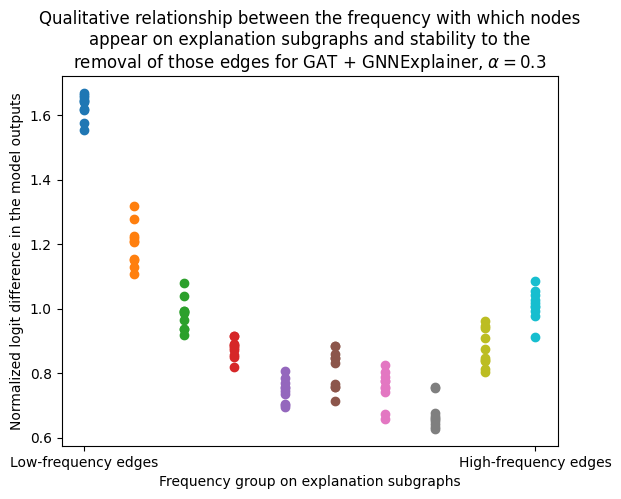

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(num_bins):
    x = [i] * num_samples
    y = GAT_GNNExplainer_results_big[i].detach().numpy()
    ax.scatter(x, y, label=f'Bin {i+1}')

ax.set_xlabel('Frequency group on explanation subgraphs')
ax.set_ylabel('Normalized logit difference in the model outputs')
ax.set_xticks([0, num_bins-1])  # Set ticks only at the extremes
ax.set_xticklabels(['Low-frequency edges', 'High-frequency edges'])
ax.set_title('Qualitative relationship between the frequency with which nodes\nappear on explanation subgraphs and stability to the\nremoval of those edges for GAT + GNNExplainer, $\\alpha=0.3$')
plt.show()

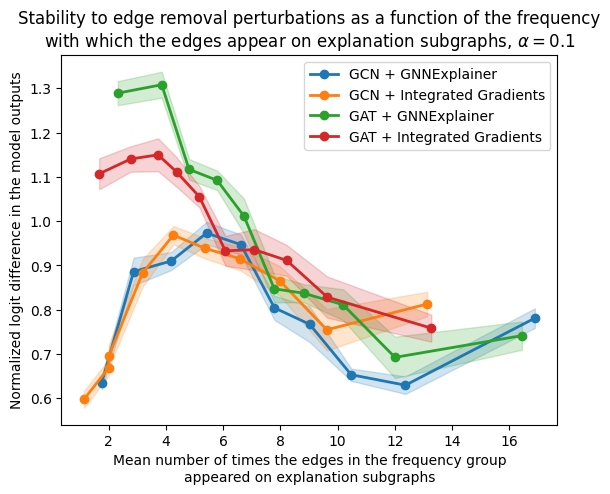

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

def plot_with_confidence_intervals(avg_freq, results, label, color):
    mean_values = np.mean(results, axis=1)
    sem_values = sem(results, axis=1)  # SEM is standard error of the mean

    # Calculate the confidence intervals (95% confidence level)
    ci_lower = mean_values - 1.96 * sem_values
    ci_upper = mean_values + 1.96 * sem_values

    plt.plot(avg_freq, mean_values, label=label, color=color, linewidth=2, marker='o')

    # Plot the confidence intervals as shaded areas
    plt.fill_between(avg_freq, ci_lower, ci_upper, color=color, alpha=0.2)

plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

plot_with_confidence_intervals(GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_small.numpy(), 'GCN + GNNExplainer', colors[0])
plot_with_confidence_intervals(GCN_IG_avg_freq_small, GCN_IG_results_small.numpy(), 'GCN + Integrated Gradients', colors[1])
plot_with_confidence_intervals(GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_small.numpy(), 'GAT + GNNExplainer', colors[2])
plot_with_confidence_intervals(GAT_IG_avg_freq_small, GAT_IG_results_small.numpy(), 'GAT + Integrated Gradients', colors[3])
# plot_with_confidence_intervals(tagcn_avg_freq_small, tagcn_results_small.numpy(), 'TAGCN', colors[2])

plt.legend()
plt.xlabel('Mean number of times the edges in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('Normalized logit difference in the model outputs')
plt.title('Stability to edge removal perturbations as a function of the frequency\nwith which the edges appear on explanation subgraphs, $\\alpha=0.1$')
plt.show()

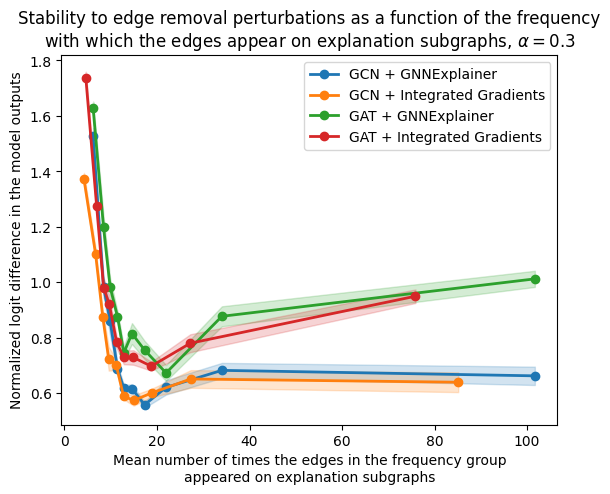

In [21]:
def plot_with_confidence_intervals(avg_freq, results, label, color):
    mean_values = np.mean(results, axis=1)
    sem_values = sem(results, axis=1)  # SEM is standard error of the mean

    # Calculate the confidence intervals (95% confidence level)
    ci_lower = mean_values - 1.96 * sem_values
    ci_upper = mean_values + 1.96 * sem_values

    plt.plot(avg_freq, mean_values, label=label, color=color, linewidth=2, marker='o')

    # Plot the confidence intervals as shaded areas
    plt.fill_between(avg_freq, ci_lower, ci_upper, color=color, alpha=0.2)

plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

plot_with_confidence_intervals(GCN_GNNExplainer_avg_freq_big, GCN_GNNExplainer_results_big.numpy(), 'GCN + GNNExplainer', colors[0])
plot_with_confidence_intervals(GCN_IG_avg_freq_big, GCN_IG_results_big.numpy(), 'GCN + Integrated Gradients', colors[1])
plot_with_confidence_intervals(GAT_GNNExplainer_avg_freq_big, GAT_GNNExplainer_results_big.numpy(), 'GAT + GNNExplainer', colors[2])
plot_with_confidence_intervals(GAT_IG_avg_freq_big, GAT_IG_results_big.numpy(), 'GAT + Integrated Gradients', colors[3])
# plot_with_confidence_intervals(tagcn_avg_freq_big, tagcn_results_big.numpy(), 'TAGCN', colors[2])

plt.legend()
plt.xlabel('Mean number of times the edges in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('Normalized logit difference in the model outputs')
plt.title('Stability to edge removal perturbations as a function of the frequency\nwith which the edges appear on explanation subgraphs, $\\alpha=0.3$')
plt.show()

In [111]:
from torch_geometric.utils import degree

node_degrees = degree(data.edge_index[0], num_nodes=data.num_nodes)
node_degrees_per_bin_gat = []
degree_one_nodes_per_bin_gat = []
degree_two_nodes_per_bin_gat = []
node_degrees_per_bin_gcn = []
degree_one_nodes_per_bin_gcn = []

for i, bin in enumerate(gat_bins_small):
    nodes_in_bin = np.unique([i[0] for i in bin])
    node_degrees_per_bin_gat.append(torch.mean(node_degrees[nodes_in_bin]).item())

for i, bin in enumerate(gcn_bins_small):
    nodes_in_bin = np.unique([i[0] for i in bin])
    node_degrees_per_bin_gcn.append(torch.mean(node_degrees[nodes_in_bin]).item())

In [112]:
for i, bin in enumerate(gat_bins_small):
    nodes_in_bin = np.unique([i[0] for i in bin])
    mask = (node_degrees[nodes_in_bin] == 1)
    mask_2 = (node_degrees[nodes_in_bin] == 2)
    degree_one_nodes_per_bin_gat.append(mask.sum().item())
    degree_two_nodes_per_bin_gat.append(mask_2.sum().item())

for i, bin in enumerate(gcn_bins_small):
    nodes_in_bin = np.unique([i[0] for i in bin])
    mask = (node_degrees[nodes_in_bin] == 1)
    degree_one_nodes_per_bin_gcn.append(mask.sum().item())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


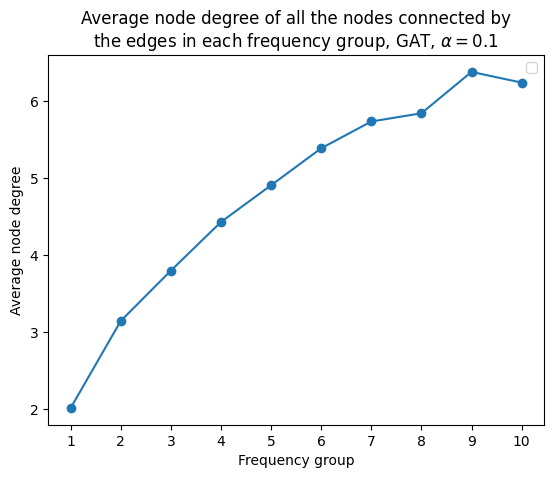

In [113]:
x = range(1, 11)

plt.figure()  # You can adjust the size of the figure
plt.plot(x, node_degrees_per_bin_gat, marker='o')  # Plot array1
# plt.plot(x, node_degrees_per_bin_gcn, label='GCN', marker='o')  # Plot array1

plt.title('Average node degree of all the nodes connected by\nthe edges in each frequency group, GAT, $\\alpha=0.1$')
plt.xticks(x)
plt.xlabel('Frequency group')
plt.ylabel('Average node degree')
plt.legend()

# Show the plot
plt.show()

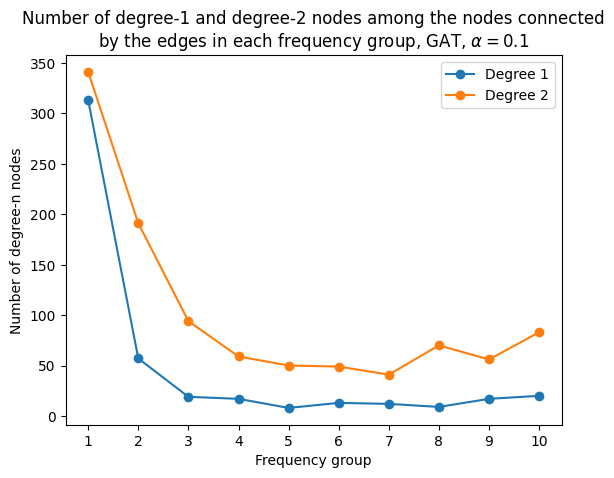

In [115]:
x = range(1, 11)

plt.figure()  # You can adjust the size of the figure
plt.plot(x, degree_one_nodes_per_bin_gat, label='Degree 1', marker='o')  # Plot array1
plt.plot(x, degree_two_nodes_per_bin_gat, label='Degree 2', marker='o')  # Plot array1

# Adding titles and labels
plt.title('Number of degree-1 and degree-2 nodes among the nodes connected\nby the edges in each frequency group, GAT, $\\alpha=0.1$')
plt.xticks(x)
plt.xlabel('Frequency group')
plt.ylabel('Number of degree-n nodes')
plt.legend()  # This adds a legend using the labels specified in the plot commands

# Show the plot
plt.show()

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx

def calculate_closeness_centrality(data):
    G = to_networkx(data, to_undirected=True)
    closeness = nx.closeness_centrality(G)
    return closeness


closeness_centralities = torch.tensor([i[1] for i in calculate_closeness_centrality(data).items()])

for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    print(torch.mean(closeness_centralities[nodes_in_bin]).item())

0.1627894937992096
0.13430961966514587
0.1475469022989273
0.14637352526187897
0.14692670106887817
0.1463272124528885
0.14773330092430115
0.14967861771583557
0.14969778060913086
0.15322807431221008


In [ ]:
def calculate_betweenness_centrality(data):
    G = to_networkx(data, to_undirected=True)
    betweenness = nx.betweenness_centrality(G)
    return betweenness


betweenness_centralities = torch.tensor([i[1] for i in calculate_betweenness_centrality(data).items()])

for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    print(torch.mean(betweenness_centralities[nodes_in_bin]).item())

0.004246211610734463
0.0032905584666877985
0.003078036243095994
0.002942989580333233
0.0028201518580317497
0.0028571796137839556
0.0029597135726362467
0.003347666235640645
0.003840755671262741
0.004714811686426401


In [ ]:
def calculate_eigenvec_centrality(data):
    G = to_networkx(data, to_undirected=True)
    centrality = nx.eigenvector_centrality(G)
    return centrality


eigenvec_centralities = torch.tensor([i[1] for i in calculate_eigenvec_centrality(data).items()])

for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    print(torch.mean(eigenvec_centralities[nodes_in_bin]).item())

0.01164113637059927
0.007233402691781521
0.0073810541070997715
0.0062959766946733
0.006511461455374956
0.0064836726523935795
0.006440081633627415
0.006205822341144085
0.007436093408614397
0.008360161446034908


In [ ]:
def calculate_clustering_coeff(data):
    G = to_networkx(data, to_undirected=True)
    clustering = nx.clustering(G)
    return clustering


clustering_coeffs = torch.tensor([i[1] for i in calculate_clustering_coeff(data).items()])

for i, bin in enumerate(bins_big):
    nodes_in_bin = np.unique([i[0] for i in bin])
    print(torch.mean(clustering_coeffs[nodes_in_bin]).item())

0.20944969356060028
0.18034528195858002
0.20606251060962677
0.23692448437213898
0.2647078335285187
0.2761887311935425
0.2894721031188965
0.2740843892097473
0.2638223171234131
0.2693707048892975
